<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/10_Time_Series_Classification_and_Regression_with_MiniRocket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Malcolm McLean and Ignacio Oguiza (oguiza@timeseriesAI.co) based on: 

* Dempster, A., Schmidt, D. F., & Webb, G. I. (2020). MINIROCKET: A Very Fast (Almost) Deterministic Transform for Time Series Classification. arXiv preprint arXiv:2012.08791.

* Original paper: https://arxiv.org/abs/2012.08791

* Original code:  https://github.com/angus924/minirocket

# MiniRocket 🚀

> A Very Fast (Almost) Deterministic Transform for Time Series Classification.

ROCKET is a type of time series classification and regression methods that is different to the 
ones you may be familiar with. Typical machine learning classifiers will 
optimize the weights of convolutions, fully-connected, and pooling layers, 
learning a configuration of weights that classifies the time series.

In contrast, ROCKET applies a large number of fixed, non-trainable, independent convolutions 
to the timeseries. It then extracts a number of features from each convolution 
output (a form of pooling), generating typically 10000 features per sample. (These 
features are simply floating point numbers.)

The features are stored so that they can be used multiple times. 
It then learns a simple linear head to predict each time series sample from its features. 
Typical PyTorch heads might be based on Linear layers. When the number of training samples is small,
sklearn's RidgeClassifier is often used.

The convolutions' fixed weights and the pooling method have been chosen experimentally to 
effectively predict a broad range of real-world time series.

The original ROCKET method used a selection of fixed convolutions with weights 
chosen according to a random distribution. Building upon the lessons learned 
from ROCKET, MiniRocket refines the convolutions to a specific pre-defined set 
that proved to be at least as effective ROCKET's. It is also much faster 
to calculate than the original ROCKET. Actually, the paper authors "suggest that MiniRocket should now be considered and used as the default variant of Rocket."

MiniROCKET was implemented in Python using numba acceleration and mathematical 
speedups specific to the algorithm. It runs quite fast, utilizing CPU cores in 
parallel. Here we present a 2 implementations of MiniRocket: 
 * a cpu version with an sklearn-like API (that can be used with small datasets - <10k samples), and
 * a PyTorch implementation of MiniRocket, optimized for 
the GPU. It runs faster (3-25x depending on your GPU) than the CPU version and offers some flexibility for further experimentation.

We'll demonstrate how you can use both of them througout this notebook.

# Import libraries 📚

In [1]:
from tsai.basics import *
import sktime
import sklearn
my_setup(sktime, sklearn)

c:\Users\karll\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.9.13
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
sktime          : 0.16.1
sklearn         : 1.1.2
torch           : 1.13.1+cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.9 GB
GPU memory      : [6.0] GB


# Using MiniRocket 🚀

* First, create the features for each timeseries sample using the MiniRocketFeatures module (MRF). 
MRF takes a minibatch of time series samples and outputs their features. Choosing an appropriate minibatch size
allows training sets of any size to be used without exhausting CPU or GPU memory.

    Typically, 10000 features will characterize each sample. These features are relatively
expensive to create, but once created they are fixed and may be used as the 
input for further training. They might be saved for example in memory or on disk.


* Next, the features are sent to a linear model. The original 
MiniRocket research used sklearn's RidgeClassifier. When the number of samples 
goes beyond the capacity of RidgeClassifier, a deep learning "Head" can be 
used instead to learn the classification/regression from minibatches of features.

For the following demos, we use the tsai package to handle timeseries efficiently and clearly. tsai is fully integrated with fastai, allowing fastai's training loop and other convenience to be used. To learn more about tsai, please check out the docs and tutorials at https://github.com/timeseriesAI/tsai

Let's get started.

## sklearn-type API (<10k samples) 🚶🏻‍♂️

We'll first import the models we are going to use:

In [2]:
from tsai.models.MINIROCKET import *

In [6]:
import sys, os
import pandas as pd


from Preprocessing.preprocessing import preprocessing


df = pd.read_csv('Data\Stock\StockBars\MSFT_Minute')
data_train, data_test ,s = preprocessing(df[:10000],sequence_length = 10, lag=3, TSAI = True, CLF = True)


### Classifier

In [11]:
# Multivariate classification with sklearn-type API

X_train, y_train, X_valid, y_valid = data_train[0].numpy(), data_train[1].numpy(), data_test[0].numpy(), data_test[1].numpy()
model = MiniRocketClassifier() 
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
print(f'valid accuracy    : {model.score(X_valid, y_valid):.3%} time: {t}')

valid accuracy    : 57.692% time: 123.289274


One way to try to improve performance is to use an ensemble (that uses majority vote). Bear in mind that the ensemble will take longer since multiple models will be fitted.

In [10]:
# Multivariate classification ensemble with sklearn-type API
model = MiniRocketVotingClassifier(n_estimators=5)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
print(f'valid accuracy    : {model.score(X_valid, y_valid):.3%} time: {t}')

valid accuracy    : 57.389% time: 617.140813


Once a model is trained, you can always save it for future inference: 

In [12]:

model.save(f'MiniRocket_{"singel"}')
del model

In [ ]:
model = load_minirocket(f'MiniRocket_{"single"}')
print(f'valid accuracy    : {model.score(X_valid, y_valid):.3%}')

## Pytorch implementation (any # samples) 🏃

In [14]:
from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *

### Offline feature calculation 

In the offline calculation, all features will be calculated in a first stage and then passed to the dataloader that will create batches. This features will ramain the same throughout training.

⚠️ In order to avoid leakage when using the offline feature calculation, it's important to fit MiniRocketFeatures using just the train samples.

In [22]:
# Create the MiniRocket features and store them in memory.
df = pd.read_csv('Data\Stock\StockBars\MSFT_Minute')
data_train, data_test ,s = preprocessing(df[:10000],sequence_length = 10, lag=3, TSAI = True, CLF = True)

X, y, splits = combine_split_data([data_train[0], data_test[0]],[data_train[1], data_test[1]])
print(torch.unique(y))

print(X.shape, y.shape)

tensor([0., 1.])
torch.Size([9975, 9, 10]) torch.Size([9975])


In [24]:
mrf = MiniRocketFeatures(X.shape[1], X.shape[2]).to(default_device())
X_train = X[splits[0]]
mrf.fit(X_train)
X_feat = get_minirocket_features(X, mrf, chunksize=1024, to_np=True)
X_feat.shape, type(X_feat)

((9975, 9996, 1), numpy.ndarray)

X_train may be a np.ndarray or a torch.Tensor. In this case we'll pass a np.ndarray. 

If a torch.Tensor is passed, the model will move it to the right device (cuda) if necessary, so that it matches the model.

We'll save this model, as we'll need it to create features in the future.

In [30]:
PATH = Path("./models/MRF.pt")
PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(mrf.state_dict(), PATH)

As you can see the shape of the minirocket features is [sample_size x n_features x 1]. The last dimension (1) is added because `tsai` expects input data to have 3 dimensions, although in this case there's no longer a temporal dimension.

Once the features are calculated, we'll need to train a Pytorch model. We'll use a simple linear model:

In [31]:
# Using tsai/fastai, create DataLoaders for the features in X_feat.
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits, batch_tfms=batch_tfms)
                 
# model is a linear classifier Head
model = build_ts_model(MiniRocketHead, dls=dls)
model.head

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(9996, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=9996, out_features=1, bias=True)
)

SuggestedLRs(valley=5.248074739938602e-05)

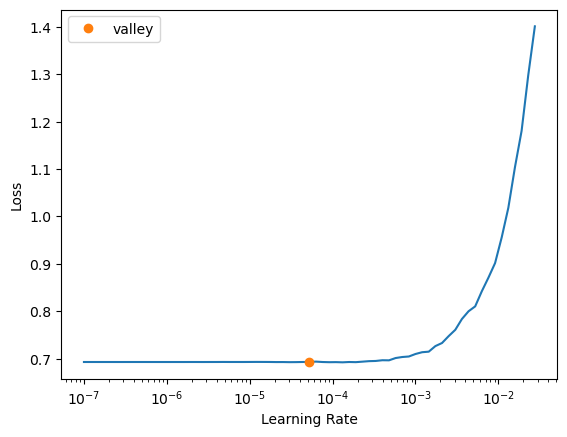

In [37]:
# Using tsai/fastai, create DataLoaders for the features in X_feat.

batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits, batch_tfms=batch_tfms)
                 
# model is a linear classifier Head
model = build_ts_model(MiniRocketHead,c_out=2, dls=dls)
                 
# Drop into fastai and use it to find a good learning rate.
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy, cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.692181,0.689216,0.542510,00:02
1,0.691119,0.685835,0.566802,00:02
2,0.687898,0.689593,0.560729,00:03
3,0.686306,0.691103,0.555668,00:03
4,0.682387,0.688422,0.566802,00:03
5,0.677909,0.686060,0.564777,00:02
6,0.671441,0.696800,0.534413,00:03
7,0.670179,0.686722,0.581984,00:03
8,0.663403,0.692572,0.569838,00:03
9,0.659610,0.690671,0.549595,00:03


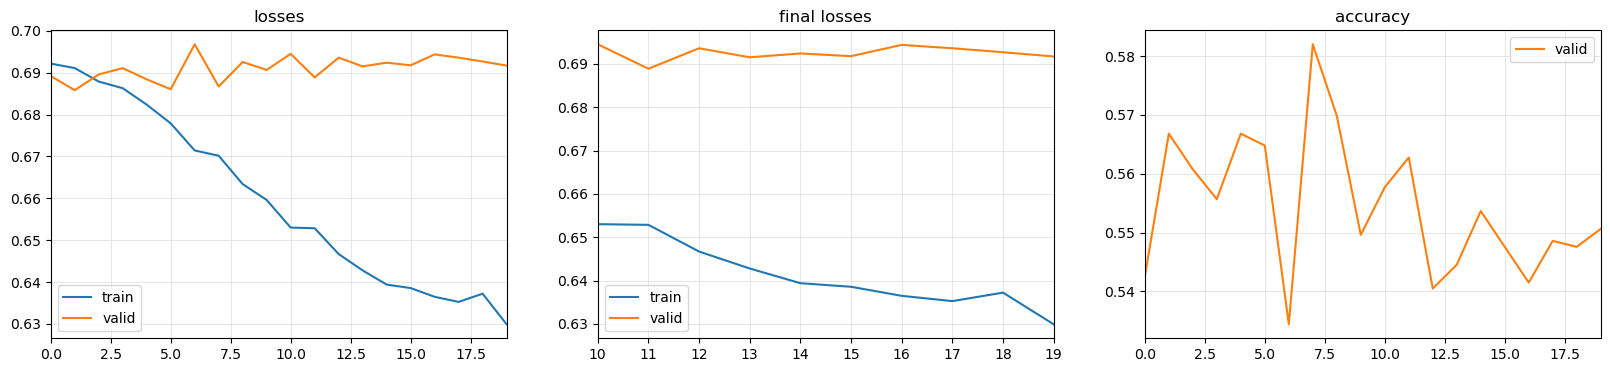

71.100347

In [40]:
# As above, use tsai to bring X_feat into fastai, and train.

batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits, batch_tfms=batch_tfms)

model = build_ts_model(MiniRocketHead,c_out=2, dls=dls)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy, cbs=ShowGraph())

timer.start()
learn.fit_one_cycle(20, 5e-5)
timer.stop()

# Conclusion ✅

MiniRocket is a new type of algorithm that is significantly faster than any other method of comparable accuracy (including Rocket), and significantly more accurate than any other method of even roughly-similar computational expense. 

`tsai` supports the 2 variations of MiniRocket introduced in this notebook. A cpu version (that can be used with relatively small datasets, with <10k samples) and a gpu (Pytorch) version that can be used with datasets of any size. The Pytorch version can be used in an offline mode (pre-calculating all features before fitting the model) or in an online mode (calculating features on the fly). 

We believe MiniRocket is a great new tool, and encourange you to try it in your next Time Series Classification or Regression task. 